In [ ]:
!pip install -q transformers datasets torch torchvision albumentations matplotlib load_dotenv
!pip install -q -U "huggingface_hub[cli]"


In [ ]:
from dotenv import load_dotenv
import os
# Load environment variables from a file named '.env' in the same directory
load_dotenv()

HUGGINGFACE_TOKEN = os.environ['HUGGINGFACE_TOKEN']
!huggingface-cli login --token $HUGGINGFACE_TOKEN --add-to-git-credential


In [ ]:
!huggingface-cli download doc2txt/tbl-unet --local-dir tbl-unet

# init

In [31]:
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
import os
import torch.nn as nn
import torchvision
import os
from PIL import Image
import numpy as np
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
import torchvision.transforms.functional as TF
import torch.optim as optim
from tqdm import tqdm
import time

BASE_PATH = "../pdfBLines/tblDS/"
# BASE_PATH = "/home/ubuntu/work/carvana/dataset/"
CHECKPOINT_PATH = "./tbl-unet/tbl_dice1.00.pth.tar"


# Hyperparameters etc.
LEARNING_RATE = 1e-5
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# print("DEVICE", DEVICE)
BATCH_SIZE = 4
NUM_EPOCHS = 200
NUM_WORKERS = 2
IMAGE_HEIGHT = 512 
IMAGE_WIDTH = 512  
PIN_MEMORY = True
LOAD_MODEL = False



# Dataset

In [32]:

class TblDataset(Dataset):
    def __init__(self, root_dir, transform=None):     
        self.root_dir = root_dir
        self.transform = transform
        
        self.images = os.listdir(self.root_dir)    
        self.images = list(filter(lambda x: "_eng.jpg" in x, self.images))
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.images[index])
        mask_path = os.path.join(self.root_dir, self.images[index].replace("_eng.jpg", "_mask.png"))
        image = Image.open(img_path).convert("L")
        mask = Image.open(mask_path).convert("L")
        mask.resize(image.size)
        image = np.array(image, dtype=np.float32)
        mask = np.array(mask, dtype=np.float32)
        mask[mask > 0] = 1.0
        
        image1,mask1 = image,mask
        if self.transform is not None:
            augmentations = self.transform(image=image,mask=mask)
            image1 = augmentations['image']
            # assert image1.shape == image.shape, f"{ image1.shape},  {image.shape}"
            mask1 = augmentations['mask']
        
            
        return image1,mask1
        

In [33]:
root_dir=os.path.join(BASE_PATH,"train")
images = os.listdir(root_dir)   
images1 = list(filter(lambda x: "_eng.jpg" in x, images))
len(images1)

1039

In [34]:
train_transform = A.Compose(
    [
        A. Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        ToTensorV2(),
    ],
)
val_transform = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        ToTensorV2(),
    ],
)


In [35]:
UnetDataset = TblDataset
train_ds = UnetDataset(
    root_dir=os.path.join(BASE_PATH,"train"),
    transform=train_transform,
)
print(os.path.join(BASE_PATH,"train"))
train_loaders = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    shuffle=True,
)
print(len(train_ds))
# val_ds = UnetDataset(
#     root_dir=os.path.join(BASE_PATH,"valid"),

#     transform=val_transform,
# )
# val_loaders = DataLoader(
#     val_ds,
#     batch_size=BATCH_SIZE,
#     num_workers=NUM_WORKERS,
#     pin_memory=PIN_MEMORY,
#     shuffle=False,
# )


../pdfBLines/tblDS/train
1039


In [36]:
for batch in train_loaders:
    images, masks = batch
    break
print("images.shape", images.shape)
print("masks.shape", masks.shape)
data, targets = next(iter(train_loaders))
print ("data.dtype", data.dtype)
print ("targets.dtype", targets.dtype)

images.shape torch.Size([4, 1, 512, 512])
masks.shape torch.Size([4, 512, 512])
data.dtype torch.float32
targets.dtype torch.float32


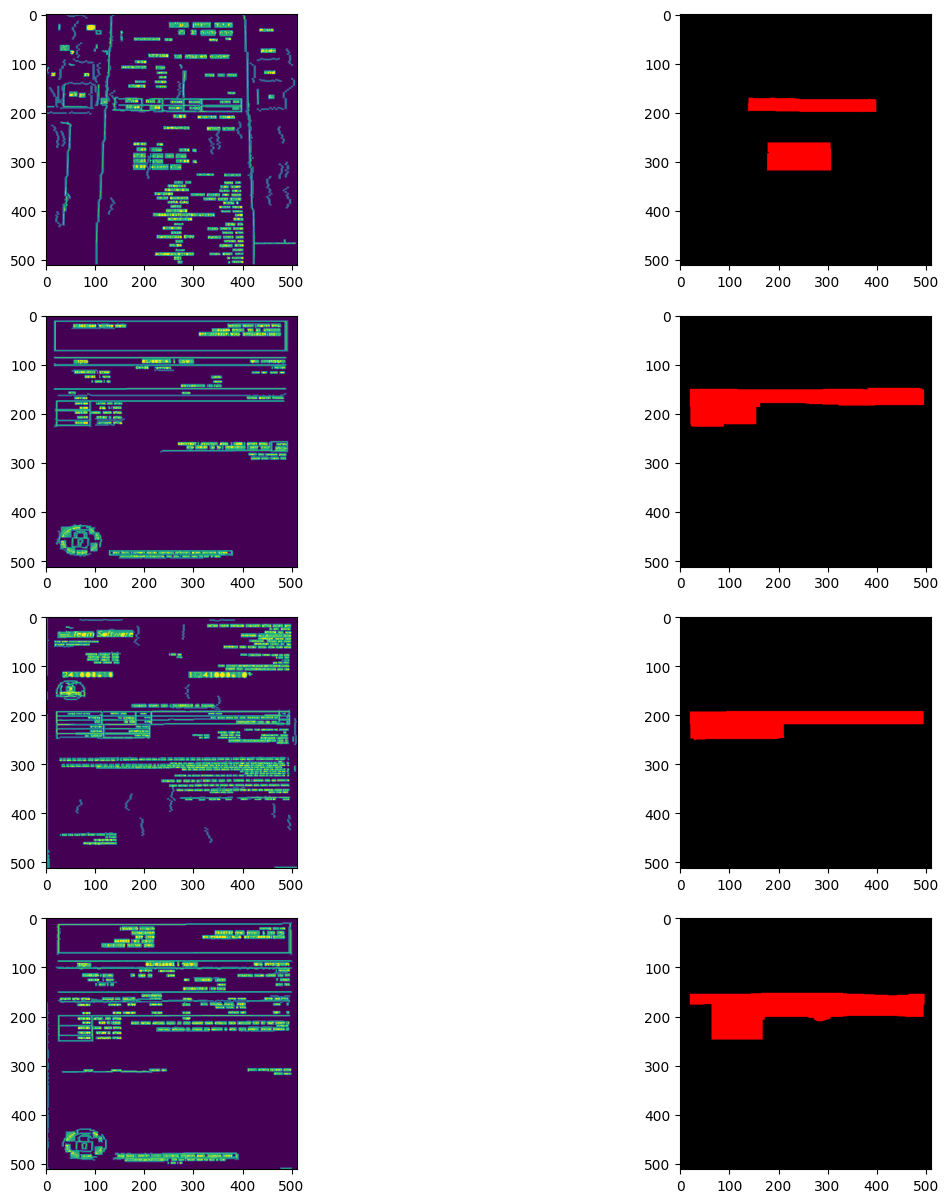

In [37]:
color_map = {
    0:(0,0,0),
    1:(255,0,0),
}

def prediction_to_vis(prediction):
    vis_shape = prediction.shape + (3,)
    vis = np.zeros(vis_shape)
    for i,c in color_map.items():
        vis[prediction == i] = color_map[i]
    return Image.fromarray(vis.astype(np.uint8))

for batch in train_loaders:
    images, masks = batch
    break

n_plots = BATCH_SIZE
f, axarr = plt.subplots(n_plots,2)
f.set_figheight(15)
f.set_figwidth(15)

for i in range(n_plots):
    image =images[i,:,:].permute(1, 2, 0)
    axarr[i,0].imshow(image)
    axarr[i,1].imshow(prediction_to_vis(masks[i,:,:]))

# Unet model

In [38]:

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels) -> None:
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            # kernel, stride, padding - same convolution
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            # kernel, stride, padding - same convolution
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)


class UNET(nn.Module):
    def __init__(self,
                 in_channels=3, out_channels=1,
                 features=[64, 128, 256, 512]
                 ) -> None:
        super(UNET, self).__init__()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2)
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)

        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        # print("Forward","x.dtype",x.dtype)
        skip_connections = []
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)

        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)


def test():
    x = torch.randn((3, 1, 161, 161))
    model = UNET(in_channels=1, out_channels=1)
    pred = model(x)
    print(pred.shape)
    print(x.shape)
    assert pred.shape == x.shape


test()

torch.Size([3, 1, 161, 161])
torch.Size([3, 1, 161, 161])


# Utils

In [39]:
def load_checkpoint(checkpoint, model):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])

def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint",filename)
    torch.save(state, filename)

def check_accuracy(loader, model, device="cuda"):
    print("Checking accuracy")
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    model.eval()

    with torch.no_grad():
        for idx, (x, y) in enumerate(loader):
            x = x.to(device)
            y = y.to(device).unsqueeze(1)
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
            
            acc = (preds == y).sum()
            numElem = torch.numel(preds)
            # print(idx, acc/numElem)
            
            num_correct += acc
            num_pixels += numElem
            dice_score += (2*(preds*y).sum())/(
                (preds+y).sum() + 1e-8
            )

        print(
            f"Got {num_correct}/{num_pixels} with acc {num_correct/num_pixels*100:.2f}"
        )

        dice = dice_score/len(loader)
        print(f"Dice score: {dice}")

        model.train()
    return dice


def save_predictions_as_imgs(
    loader, model, folder="saved_images/", device="cuda"
):
    print("Saving predictions")
    start = time.time()
    model.eval()
    for idx, (x, y) in enumerate(loader):
        x = x.to(device=device)
        with torch.no_grad():
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
        torchvision.utils.save_image(
            preds, os.path.join(folder,f"pred_{idx}.png")
        )
        torchvision.utils.save_image(y.unsqueeze(1), 
                                    os.path.join(folder,f"correct_{idx}.png")
                                     )
    print(f"Saved predictions in {time.time()-start:.2f} seconds")
    model.train()


# Train

In [40]:
model = UNET(in_channels=1, out_channels=1).to(DEVICE)

In [41]:
load_checkpoint(torch.load(CHECKPOINT_PATH), model)
# check_accuracy(val_loaders, model, device=DEVICE)     

=> Loading checkpoint


In [42]:
def train_fn(loader, model, optimizer, loss_fn, scaler):
    loop = tqdm(loader)
    for batch_idx, (data, targets) in enumerate(loop):
    # for i in range(10):
    #     data, targets = next(iter(loader))
        
        data = data.to(device=DEVICE)
        targets = targets.float().unsqueeze(1).to(device=DEVICE)

        # forward
        with torch.cuda.amp.autocast():
            predictions = model(data)
            loss = loss_fn(predictions, targets)

        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        # print("loss", loss.item())

        # update tqdm
        loop.set_postfix(loss=loss.item())

In [43]:
# pos_weight = torch.ones([224]).to(DEVICE)
# loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
loss_fn = nn.BCEWithLogitsLoss()
# loss_fn = DiceLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

scaler = torch.cuda.amp.grad_scaler.GradScaler()
for epoch in range(NUM_EPOCHS):
    print("epoch", epoch)
    train_fn(train_loaders, model, optimizer, loss_fn, scaler)





    # print some example to folder
    if epoch % 10 == 0:
        # save model
        check_point = {
            "state_dict": model.state_dict(),
            "optimizer": optimizer.state_dict(),
        }
        # dice_score =check_accuracy(val_loaders, model, device=DEVICE)        
        # save_checkpoint(check_point, os.path.join(CHECKPOINT_PATH,f"blines_dice{dice_score}.pth.tar"))        
        # save_predictions_as_imgs(
        #     val_loaders, model, folder="save_images/", device=DEVICE
        # )


epoch 0


 23%|██▎       | 61/260 [00:12<00:38,  5.11it/s, loss=0.184]

In [ ]:
# dice_score =check_accuracy(val_loaders, model, device=DEVICE)        
save_checkpoint(check_point, CHECKPOINT_PATH)        
# save_checkpoint(check_point, os.path.join(CHECKPOINT_PATH,f"blines_dice{dice_score:.2F}.pth.tar"))        


In [ ]:
!huggingface-cli upload doc2txt/tbl-unet ./tbl-unet .

 # view results

In [ ]:
# loader = train_loaders
# folder="./save_images"
# device=DEVICE

# try:
#     os.mkdir(folder)
# except FileExistsError:
#     print("Directory ",folder," already exists")


In [ ]:
# for idx, (x, y) in enumerate(train_loaders):
#     x = x.to(device=device)
#     with torch.no_grad():
#         preds = torch.sigmoid(model(x))
#         preds = (preds > 0.5).float()
#     torchvision.utils.save_image(preds, os.path.join(folder,f"pred_{idx}.png"))
#     torchvision.utils.save_image(y.unsqueeze(1), os.path.join(folder,f"correct_{idx}.png"))

In [ ]:

for idx, (pixel_values,masks) in enumerate(train_loaders):
# for idx, (pixel_values,masks) in enumerate(val_loaders):
    pixel_values = pixel_values.to(DEVICE)
    print(idx, pixel_values.shape)
    preds = torch.sigmoid(model(pixel_values))
    predicted_mask = (preds > 0.5).float()
    masks = masks.cpu().numpy()
    break # only one batch


In [ ]:
print("predicted_mask.shape",predicted_mask.shape)
print("masks.shape",masks.shape)

In [ ]:
color_map = {
    0:(0,0,0),
    1:(255,0,0),
}

def prediction_to_vis(prediction):
    vis_shape = prediction.shape + (3,)
    vis = np.zeros(vis_shape)
    for i,c in color_map.items():
        vis[prediction == i] = color_map[i]
    return Image.fromarray(vis.astype(np.uint8).squeeze())
n_plots = 8
from matplotlib import pyplot as plt
f, axarr = plt.subplots(n_plots,2)
f.set_figheight(15)
f.set_figwidth(15)
for i in range(n_plots):
    axarr[i,0].imshow(prediction_to_vis(predicted_mask[i,:,:].cpu()))
    axarr[i,1].imshow(prediction_to_vis(masks[i,:,:]))

In [ ]:
#Predict on a test image and overlay the mask on the original image
ds = train_ds
test_idx = 0
input_image_file = os.path.join(ds.root_dir,ds.images[test_idx])
input_image = Image.open(input_image_file)
test_batch = ds[test_idx]
images, masks = test_batch
images = torch.unsqueeze(images, 0)
masks = torch.unsqueeze(masks, 0)
images= images.to(DEVICE)
outputs = model(images)
preds = torch.sigmoid(outputs)
predicted_mask = (preds > 0.5).float()


mask = prediction_to_vis(predicted_mask[test_idx,:,:].cpu())
mask = mask.resize(input_image.size)
mask = mask.convert("RGBA")
input_image = input_image.convert("RGBA")
overlay_img = Image.blend(input_image, mask, 0.5)
overlay_img